In [1]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [2]:
%load_ext rpy2.ipython

In [3]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Precio en dolares"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()

#  Importación de datos

In [4]:
import yfinance as yf

ticker_name = 'BC'

data = yf.download(ticker_name, start='2003-06-01', end='2013-06-01')
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(2518, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-06-02,22.080000,22.490000,22.049999,22.200001,16.651117,519800
2003-06-03,22.200001,22.480000,22.200001,22.400000,16.801123,327000
2003-06-04,22.370001,23.139999,22.370001,23.000000,17.251158,444100
2003-06-05,22.900000,23.240000,22.799999,23.150000,17.363670,394200
2003-06-06,25.010000,25.080000,24.100000,24.150000,18.113718,905600


In [5]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index)
df["Close"] = data["Close"].values
display(df.head(10))
display(df.shape)

df_completo = df.copy()
df_completo.set_index('Date', inplace=True)
df_completo = df_completo.resample('1D').mean().ffill()
display(df_completo.head(10))
df_completo.shape

,Date,Close
0,2003-06-02,22.200001
1,2003-06-03,22.400000
2,2003-06-04,23.000000
3,2003-06-05,23.150000
4,2003-06-06,24.150000
5,2003-06-09,24.540001
6,2003-06-10,24.660000
7,2003-06-11,25.120001
8,2003-06-12,25.090000
9,2003-06-13,25.170000


(2518, 2)

,Close
Date,
2003-06-02,22.200001
2003-06-03,22.400000
2003-06-04,23.000000
2003-06-05,23.150000
2003-06-06,24.150000
2003-06-07,24.150000
2003-06-08,24.150000
2003-06-09,24.540001
2003-06-10,24.660000


(3652, 1)

In [6]:

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size+val_size]
test_data = df_completo.iloc[train_size+val_size:]

plot_("Train and Test Data",
      (train_data.index, train_data['Close'], "Train Data"),
      (test_data.index, test_data['Close'], "Test Data"),
      (val_data.index, val_data['Close'], "Validation Data"))

## Redes neuronales

Este código implementa una red neuronal para predecir precios de cierre de una serie temporal utilizando la búsqueda de hiperparámetros con Keras Tuner.

Se optimizan los siguientes hiperparámetros para el modelo de red neuronal:

- **Número de capas ocultas (`n_layers`)**: Determina la cantidad de capas ocultas en la red neuronal. Los valores probados son 2 y 3.
- **Número de unidades por capa (`units_i`)**: Especifica el número de neuronas en cada capa oculta. Los valores probados son 64 y 128. El índice `i` se refiere a la capa específica.
- **Función de activación (`activation_i`)**: Define la función de activación utilizada en cada capa oculta. Las opciones son `'relu'` y `'tanh'`.

**Parámetros fijos**:

- **Número de épocas**: 100 épocas para la búsqueda de hiperparámetros y 50 épocas para el entrenamiento final del modelo.
- **Optimización**: Se utiliza el optimizador `'adam'` y la función de pérdida `'mse'`.
- **Tamaño del batch**: No se especifica, por lo que se usa el tamaño por defecto de TensorFlow.
- **Detección temprana**: Se usa una callback de `EarlyStopping` con `patience=5`, que detiene el entrenamiento si la pérdida de validación no mejora durante 5 épocas.

**Lags**:

- **Lag**: El código evalúa lags desde 1 hasta 20 para determinar el mejor valor. El mejor lag se selecciona en función del error de validación (`val_loss`).

Después de encontrar el mejor lag y los mejores hiperparámetros, el modelo final se entrena, se guarda, y se evalúa en los conjuntos de datos de entrenamiento, validación y prueba, reportando **R2** y **RMSE**. Las **predicciones** se desnormalizan para la interpretación final y se visualiza la **pérdida durante el entrenamiento** para evaluar el comportamiento del modelo.


Trial 25 Complete [00h 00m 19s]
val_loss: 0.00011595881126898651

Best val_loss So Far: 0.00011509392303802694
Total elapsed time: 00h 06m 21s
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Reloading Tuner from my_dir/NN_hyperparameters/tuner0.json
Error getting best model: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(2, 128), Received: value.shape=(1, 128). Target variable: <KerasVariable shape=(2, 128), dtype=float32, path=sequential/dense/kernel>

List of objects that could not be loaded:
[<Dense name=dense, built=True>]
Falling back to manually selecting the best trial...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Reloading Tuner from my_dir/NN_hyperparameters/tuner0.json
Error getting best model: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

The sha

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training - R2: 0.9987, RMSE: 0.0104
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation - R2: 0.9780, RMSE: 0.0108
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test - R2: 0.9905, RMSE: 0.0110

Best hyperparameters:
Number of hidden layers: 2
Layer 1:
  Units: 128
  Activation: relu
Layer 2:
  Units: 128
  Activation: relu


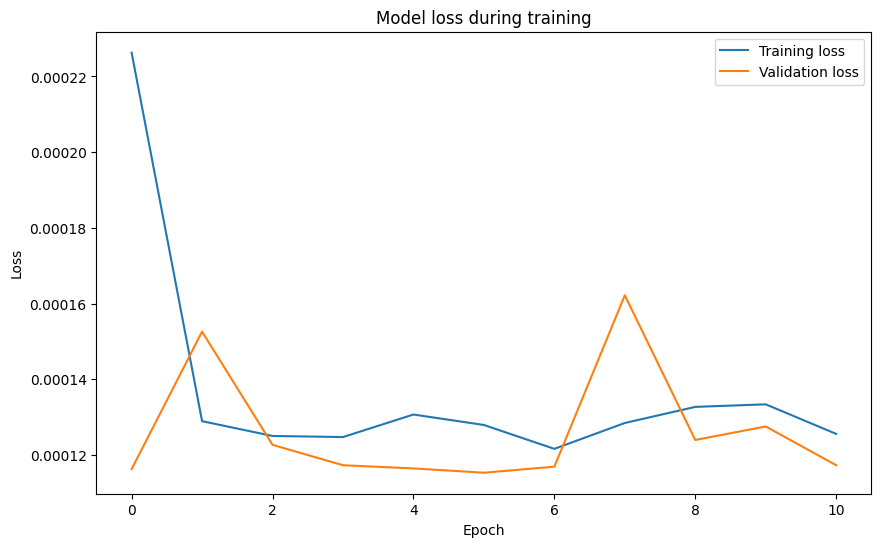

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
import os
import shutil

# Assuming that df_completo is your original DataFrame with the columns 'Date' and 'Close'

def create_features(data, lag):
    df = pd.DataFrame(index=data.index)
    df['target'] = data['Close']
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = data['Close'].shift(i)
    return df.dropna()

# Function to evaluate the model
def evaluate_model(model, X, y):
    predictions = model.predict(X).flatten()
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    return mse, r2, predictions

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size+val_size]
test_data = df_completo.iloc[train_size+val_size:]

# Clear previous results
tuner_dir = 'my_dir/NN_hyperparameters'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

# Search for the best lag
best_lag = 0
best_val_loss = np.inf

for lag in range(1, 21):  # Test lags from 1 to 20
    # Create features for train, validation, and test
    train_features = create_features(train_data, lag)
    val_features = create_features(val_data, lag)
    test_features = create_features(test_data, lag)

    # Separate features (X) and target (y)
    X_train = train_features.drop('target', axis=1)
    y_train = train_features['target']
    X_val = val_features.drop('target', axis=1)
    y_val = val_features['target']
    X_test = test_features.drop('target', axis=1)
    y_test = test_features['target']

    # Normalize the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # Define the model with adjustable hyperparameters
    def build_model(hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))

        # Number of hidden layers (2 or 3)
        n_layers = hp.Choice('n_layers', values=[2, 3])

        for i in range(n_layers):
            # Number of neurons per layer (64 or 128)
            units = hp.Choice(f'units_{i}', values=[64, 128])
            # Activation function (relu or tanh)
            activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
            
            model.add(layers.Dense(units=units, activation=activation))

        model.add(layers.Dense(1))

        model.compile(optimizer='adam', loss='mse')
        return model

    # Configure the hyperparameter search
    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=25,
        executions_per_trial=3,
        directory='my_dir',
        project_name='NN_hyperparameters'
    )

    # Perform the search
    tuner.search(X_train_scaled, y_train_scaled, epochs=100, validation_data=(X_val_scaled, y_val_scaled), 
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

    # Get the best model and evaluate its validation loss
    try:
        best_model = tuner.get_best_models(num_models=1)[0]
    except ValueError as e:
        print(f"Error getting best model: {e}")
        print("Falling back to manually selecting the best trial...")
        
        # Fallback: Manually select the best trial and rebuild the model
        best_trial = tuner.oracle.get_best_trials(1)[0]
        best_hp = best_trial.hyperparameters
        
        best_model = build_model(best_hp)
        best_model.fit(X_train_scaled, y_train_scaled, epochs=100, 
                       validation_data=(X_val_scaled, y_val_scaled), 
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                       verbose=0)

    val_mse, _, _ = evaluate_model(best_model, X_val_scaled, y_val_scaled)
    best_val_loss_current = val_mse
    
    if best_val_loss_current < best_val_loss:
        best_val_loss = best_val_loss_current
        best_lag = lag

print(f"Best lag: {best_lag}")

# Create final features with the best lag
train_features = create_features(train_data, best_lag)
val_features = create_features(val_data, best_lag)
test_features = create_features(test_data, best_lag)

# Separate features (X) and target (y)
X_train = train_features.drop('target', axis=1)
y_train = train_features['target']
X_val = val_features.drop('target', axis=1)
y_val = val_features['target']
X_test = test_features.drop('target', axis=1)
y_test = test_features['target']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Train the best model
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train_scaled, y_train_scaled, epochs=50, 
                        validation_data=(X_val_scaled, y_val_scaled), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                        verbose=0)

# Save the best model
best_model.save('best_model.h5')

# Evaluate the model on the training, validation, and test sets
def evaluate_model_final(model, X, y, set_name):
    predictions = model.predict(X).flatten()
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    print(f"{set_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}")
    return predictions

train_pred = evaluate_model_final(best_model, X_train_scaled, y_train_scaled, "Training")
val_pred = evaluate_model_final(best_model, X_val_scaled, y_val_scaled, "Validation")
test_pred = evaluate_model_final(best_model, X_test_scaled, y_test_scaled, "Test")

# Denormalize the predictions
train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).flatten()
val_pred = scaler_y.inverse_transform(val_pred.reshape(-1, 1)).flatten()
test_pred = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()

# Print the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest hyperparameters:")
print(f"Number of hidden layers: {best_hp.get('n_layers')}")
for i in range(best_hp.get('n_layers')):
    print(f"Layer {i+1}:")
    print(f"  Units: {best_hp.get(f'units_{i}')}")
    print(f"  Activation: {best_hp.get(f'activation_{i}')}")

# Visualize the loss during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Print the best lag
print(f"Best lag: {best_lag}")

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Print the best hyperparameters
print("\nBest hyperparameters:")
print(f"Number of hidden layers: {best_hp.get('n_layers')}")
for i in range(best_hp.get('n_layers')):
    print(f"Layer {i+1}:")
    print(f"  Units: {best_hp.get(f'units_{i}')}")
    print(f"  Activation: {best_hp.get(f'activation_{i}')}")

# Optionally, you can also print the best validation loss
best_model = tuner.get_best_models(1)[0]
_, best_val_loss, _ = evaluate_model(best_model, X_val_scaled, y_val_scaled)
print(f"\nBest validation loss: {best_val_loss:.6f}")

Best lag: 1

Best hyperparameters:
Number of hidden layers: 2
Layer 1:
  Units: 128
  Activation: relu
Layer 2:
  Units: 128
  Activation: relu
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Best validation loss: 0.978411


El modelo de red neuronal con **lag de 1** presenta un **MSE de 0.277535**. Este modelo utiliza **2 capas ocultas**, cada una con **128 unidades** y **función de activación 'relu'**. La elección de un lag de 1 sugiere que solo se necesita el valor de cierre del día anterior para obtener un buen rendimiento. La consistencia en el número de unidades y la función de activación en ambas capas implica que el modelo tiene una estructura simple pero efectiva para esta tarea de predicción.


In [9]:
date = test_data.index + pd.DateOffset(days=best_lag)

plot_("Predicciones de la Serie Temporal",
      (test_data.index, test_data['Close'], "Datos de Prueba"),
      (date, test_pred, "Predicciones"))

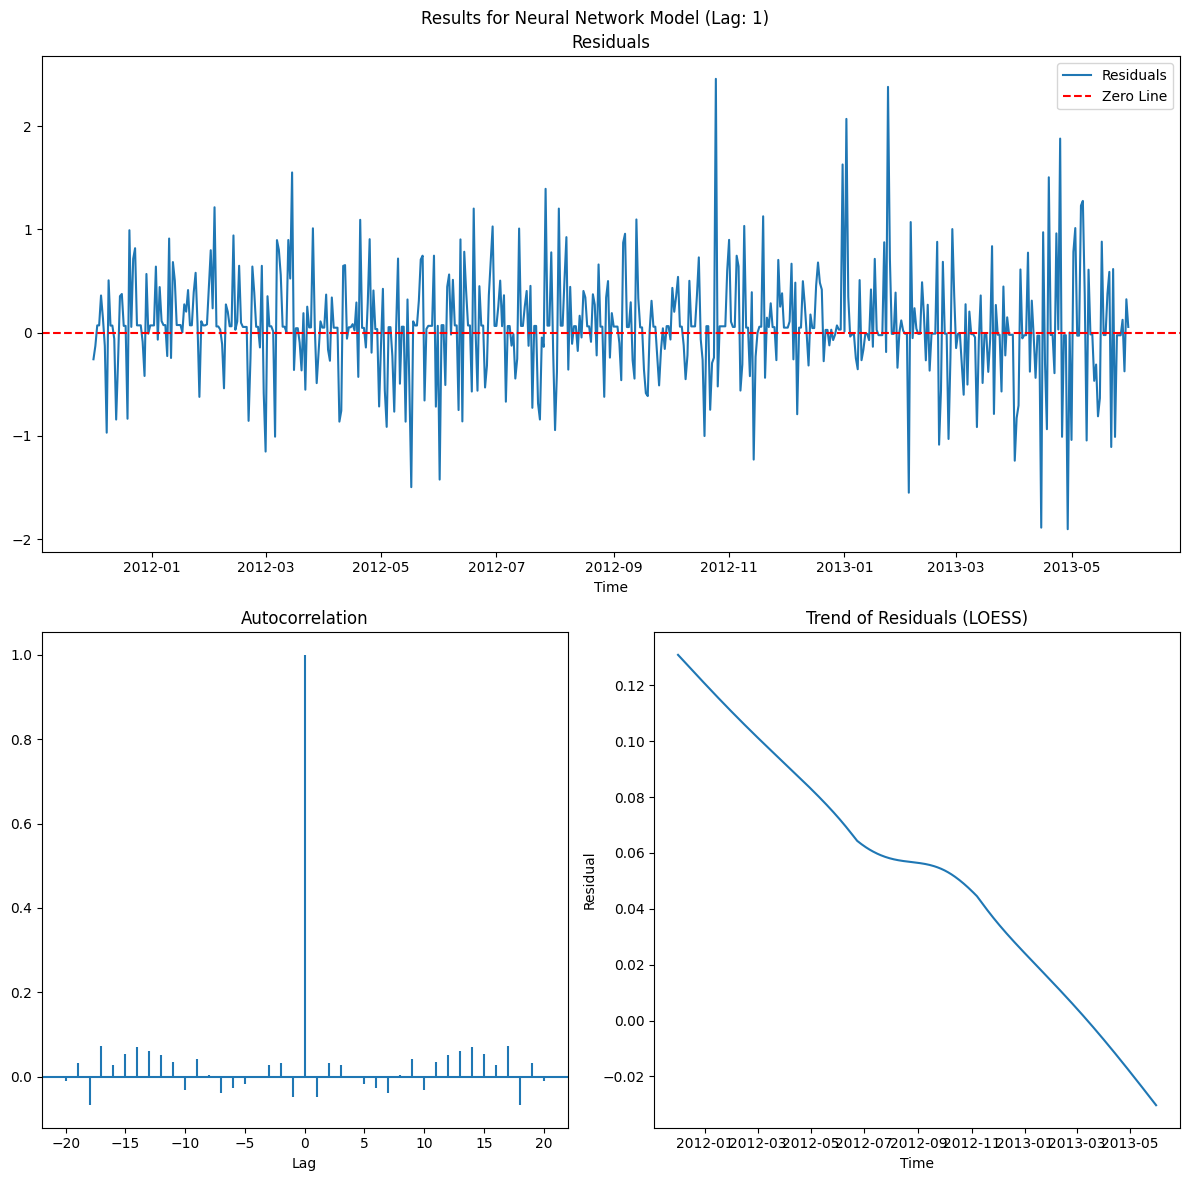

,Model,Lag,MSE,Layers,Layer_1_Units,Layer_1_Activation,Layer_2_Units,Layer_2_Activation
0,Neural Network,1,0.277535,2,128,relu,128,relu


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

def analyze_nn_results(test_data, y_test, test_pred, best_lag, best_hp):
    # Calculate residuals
    test_residual = y_test - test_pred

    # Create figure
    fig, axs = plt.subplot_mosaic("AA;BC", figsize=(12, 12))
    plt.suptitle(f'Results for Neural Network Model (Lag: {best_lag})')

    # Residuals
    axs["A"].plot(test_data.index[best_lag:], test_residual)
    axs["A"].set_title('Residuals')
    axs["A"].set_xlabel('Time')
    axs["A"].axhline(0, color='red', linestyle='--')
    axs["A"].legend(['Residuals', 'Zero Line'])

    # Autocorrelation
    axs["B"].acorr(test_residual, maxlags=20)
    axs["B"].set_title('Autocorrelation')
    axs["B"].set_xlabel('Lag')

    # Trend of Residuals (LOESS)
    lowess = sm.nonparametric.lowess(test_residual, np.arange(len(test_residual)), frac=0.75)
    axs["C"].plot(test_data.index[best_lag:], lowess[:, 1])
    axs["C"].set_title('Trend of Residuals (LOESS)')
    axs["C"].set_xlabel('Time')
    axs["C"].set_ylabel('Residual')

    plt.tight_layout()
    plt.show()

    # Calculate MSE
    mse = mean_squared_error(y_test, test_pred)

    # Create and display DataFrame with results
    mse_results = pd.DataFrame({
        "Model": ["Neural Network"],
        "Lag": [best_lag],
        "MSE": [mse],
        "Layers": [best_hp.get('n_layers')]
    })

    for i in range(best_hp.get('n_layers')):
        mse_results[f"Layer_{i+1}_Units"] = best_hp.get(f'units_{i}')
        mse_results[f"Layer_{i+1}_Activation"] = best_hp.get(f'activation_{i}')

    display(mse_results)

    return mse_results, fig

# Usage example:
mse_results, fig = analyze_nn_results(test_data, y_test, test_pred, best_lag, best_hp)

Se observa discrepancias positiva en el 2012-11 y negativa en  2013-05, aunque explica claramente la tendencia, y la autocrrelación de los datos.